<a href="https://colab.research.google.com/github/carinunez/Tareas_generativos/blob/main/Tarea_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 4: Modelos basados en energía

### MDS7203 Modelos Generativos Profundos

**Nombre:**

**Fecha de entrega:**

En esta cuarta tarea se evaluarán los fundamentos de los modelos basados en energía, colocando énfasis en los modelos basados en score, los cuales, como sabemos, son esenciales para construir buenos modelos generativos condicionales mediante las técnicas de guidance. Además, el aprendizaje basado en score es relevante para formular modelos de difusión, tanto en su versión a tiempo discreto como en su versión continua.

Algunas instrucciones generales:

- Se pueden utilizar de manera libre herramientas como ChatGPT y Claude, entre otras.
- Para la entrega, no es necesario un informe, este archivo es suficiente.
- Se debe entregar el documento con todas las celdas ejecutadas.
- Esta tarea puede ser resuelta en Google Colab o de manera local (no se utilizará GPU).
- La tarea está compuesta por dos partes, una conceptual y otra práctica. Ambas partes valen lo mismo.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm
from sklearn.datasets import make_swiss_roll

## Parte 1 (preguntas conceptuales)

### Modelos basados en energía

Un modelo basado en energía (EBM) clásico busca aprender una distribución de probabilidad desconocida $p_\text{data}(x)$ parametrizando una función de densidad $p_\theta(x)$ a partir de una red neuronal $E_\theta:\R^D\to\R$ mediante la expresión

$$
p_\theta(x)=\frac{\exp\left(-E_\theta(x)\right)}{Z_\theta},
\quad\text{donde}\quad Z_\theta=\int_{\R^D} \exp\left(-E_\theta(x)\right)\text{d}x
\quad\text{es la constante de normalización.}
$$

- ¿Por qué no es posible en general computar la log-verosimilitud $\log p_\theta(x)$? Si esta cantidad no es tratable, ¿cómo es posible entrenar un EBM mediante el criterio de máxima verosimilitud?
> **Respuesta:** Primero que nada es necesario saber de que la función $p_\thetha(x)$ se divide por la constante de normalización para que cumpla con el criterio de sumar 1 para ser una función de probabilidad, pero el problema es que no se conoce el valor de la constante y además no se puede computar porque la integral sobre Rd posee dimensiones altísimas (sobre todo en caso de imágenes), lo que hace costoso el proceso de cálculo.  
Para lo anterior se busca entonces una alternativa, la cual es estimar por máxima verosimilitud, llegando a $$
\log p_\theta(x) = -E_\theta(x) - \log Z_\theta
$$ , ojo, a pesar de eso no se puede estimar aún porque el log de la constante sigue siendo desconocida, aún al aplicar el gradiente de forma directa $$
\nabla_\theta \log p_\theta(x) = -\nabla_\theta E_\theta(x) - \nabla_\theta \log Z_\theta
$$, pero si usamos el truco de reescribir esa función en base a las propiedades del gradiente.
$$
\nabla_\theta \log Z_\theta
= \frac{1}{Z_\theta} \nabla_\theta Z_\theta
= \frac{1}{Z_\theta} \nabla_\theta \int \exp(-E_\theta(x))\, dx
= - \int p_\theta(x) \nabla_\theta E_\theta(x)\, dx
= - \mathbb{E}_{x \sim p_\theta}[\nabla_\theta E_\theta(x)]
$$
Entonces ahora podemos calcular el $$\log Z_\theta$$ como una esperanza, siendo la función objetivo:
$$
\nabla_\theta \log p_\theta(x) = -\nabla_\theta E_\theta(x) + \mathbb{E}_{x \sim p_\theta}[\nabla_\theta E_\theta(x)]
$$
si nos fijamos ya no dependemos del z por lo que se pueden estimar los parámetors con una red neuronal


- ¿Para qué se utiliza la dinámica de Langevin en este tipo de modelos? ¿Por qué es importante este algoritmo para el entrenamiento?
> **Respuesta:**
- ¿Por qué es lento entrenar directamente la función de energía $E_\theta$ utilizando el enfoque de máxima verosimilitud?
> **Respuesta:**

### Modelos basados en score

Una posible reparametrización de este tipo de modelos consiste en aprender la función de score $\nabla_x \log p_\theta(x)$ entrenando una red neuronal $s_\theta:\R^D\to\R^D$ en vez de entrenar la función de energía $E_\theta:\R^D\to\R$ descrita anteriormente. Para esto, se suele usar como función objetivo la divergencia de Fisher:

$$
\operatorname{D_F}\left(p_{\text{data}}(x)\|p_\theta(x)\right):= \mathbb{E}_{p_{\text{data}}(x)}\left[\frac{1}{2}\left\|\nabla_x\log p_\theta(x)-\nabla_x\log p_{\text{data}}(x)\right\|^2\right]
$$

Si bien esta cantidad no es directamente computable (ya que no se conoce el score real $\nabla_x\log p_{\text{data}}(x)$), en clases se demostró que la divergencia de Fisher toma la siguiente forma tratable para su optimización:

$$
\operatorname{D_F}\left(p_{\text{data}}(x)\|p_\theta(x)\right) = \mathbb{E}_{p_{\text{data}}(x)}\left[\frac{1}{2}\left\|s_\theta(x)\right\|^2 + \operatorname{Div}\left( s_\theta(x)\right)\right] + \operatorname{constante}
$$

Al entrenamiento de un modelo basado en score utilizando esta función objetivo se le suele llamar score matching (SM).

- ¿Cuál es la motivación para aprender el score $\nabla_x \log p_\theta(x)$ en vez de la función de energía $E_\theta(x)$ asociada a $p_\theta(x)$? Relaciónelo con la dinámica de Lanvegin.
> **Respuesta:**
- ¿Cuál es la principal limitación del enfoque SM que motiva a usar técnicas alternativas como denoising score matching (DSM)?
> **Respuesta:**

### Guidance

Una de las propiedades más importantes de los modelos basados en score es que permiten aplicar la técnica de guidance para realizar generación condicional. Como vimos en clases, esta técnica es esencial en los modelos de difusión para poder obtener buenos resultados que se ajusten al prompt dado como factor condicionante.

- ¿Qué elemento adicional necesita la técnica de classifier guidance para realizar generación condicional a partir de un modelo de score entrenado de forma incondicional? ¿Cuál es la principal limitación de este método?
> **Respuesta:**
  Classifier Guidance necesita de un Clasificador entrenado sobre los datos generados por el modelo que sea capaz ded predecir la prob de una clase respecto a la muestra, i.e $p(y|x)$, es importante que este clasificador sea diferenciable c/r a x.
  La principal limitación de este método es que el clasificado debe ser robusto y preciso para que pueda operar sobre muestras con distintos niveles de ruido, lo que hace que sea costoso computacionalmente.



- La técnica de classifier-free guidance es una modificación de la técnica de classifier guidance que permite realizar generación condicional pero ahora utilizando un modelo de score entrenado de forma condicional.
¿Cuáles son las ventajas de usar este enfoque en vez de utilizar directamente el modelo de score condicional ya entrenado? ¿Por qué ya no es necesario entrenar un clasificador con este enfoque?
> **Respuesta:**
  Dado que en CFG se quita el clasificador, entonces podemos controlar la importancia que le damos al prior de clase (Prompt Adherence). Además, es menos costoso dado que no se necesita entrenar y mantener un clasificador robusto. Por otro lado, esta técnica es más estable pues el modelo conoce internamente como usar la condición.

  Con esta técnica deja de ser necesario un clasificador externo porque el modelo de score aprende a diferenciar entre estar condicionado y no estarlo.
  


## Parte 2 (implementación)

En esta segunda parte se pide implementar la técnica de score matching original (i.e., la que optimiza la cantidad $\operatorname{D_F}\left(p_{\text{data}}(x)\|p_\theta(x)\right) = \mathbb{E}_{p_{\text{data}}(x)}\left[\frac{1}{2}\left\|s_\theta(x)\right\|^2 + \operatorname{Div}\left( s_\theta(x)\right)\right] + \operatorname{constante}$). Para esto, se trabajará con el mismo dataset de juguete que se utiliza en clases:

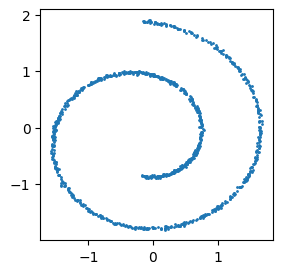

In [4]:
def get_batch(batch_size=100, noise=0.1):
    x, _ = make_swiss_roll(batch_size, noise=noise)
    x = x[:, [0, 2]]
    x = (x - x.mean()) / x.std()
    return torch.tensor(x).float()

# Ejemplo:
samples = get_batch(batch_size=1000)
plt.figure(figsize=(3, 3))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

### Clase `SM`

La siguiente clase se utilizará entrenar un modelo basado en score utilizando el enfoque DSM (ya implementado) o el enfoque SM (se debe implementar). Para esto, el parámetro `dsm` en el método `train_model` permite indicar qué enfoque se utilizará para el entrenamiento.

- Complete el código del método `train_model` para obtener `loss` mediante el método de SM.
- Implemente el método `generate_samples` que genera nuevas muestras utilizando la dinámica de Langevin.

In [15]:
class SM:

    @staticmethod
    def train_model(net, optimizer, dsm, n_iters):

        for _ in tqdm.trange(n_iters):

            x = get_batch()

            # ---------------- Cálculo de loss ----------------

            # Denoising score matching.
            if dsm:
                sigma = 0.1
                x_bar = x + sigma * torch.randn_like(x)
                score = net(x_bar)
                inner = (x - x_bar) / sigma**2 - score
                loss =  1/2 * (torch.linalg.norm(inner, dim=-1) ** 2).mean()

            # Score matching.
            else:
                # Score Matching
                # Loss: E_{p_data}[ 0.5*||S_theta(x)||^2 + Tr(J_x s_theta(x))]

                x.requires_grad_(True) # me aseguro que x requiera gradientes
                score = net(x) #S_theta(x)
                norm_score = 0.5* (torch.linalg.norm(score, dim=-1)**2).mean()

                traza = 0
                for i in range(x.shape[1]):

                  s_i = score[:, i].sum()
                  # Grad de la componente i-ésima de x
                  grad_s_i = torch.autograd.grad(
                      outputs=s_i,
                      inputs=x,
                      create_graph=True)[0]

                  # Traza(J_x(S_i))
                  traza += 2 * grad_s_i[:, i].mean()
                loss = norm_score + traza

            # ---------------- Optimización ----------------
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    @staticmethod
    def generate_samples(net, n_samples, step_size=0.001, n_steps=1000):

        with torch.no_grad():
          x = torch.rand((n_samples, 2))
          for _ in range(n_steps):
              epsilon = torch.randn_like(x)
              x = x + step_size * net(x) + (2 * step_size) ** 0.5 * epsilon
          return x

### Red neuronal

Dado que se está trabajando con un dataset de juguete, es suficiente considerar una red fully connected para aprender la función de score:

In [13]:
class ScoreNetwork(nn.Module):

    def __init__(self, data_dim):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(data_dim, 64), nn.LogSigmoid(),
            nn.Linear(64, 64), nn.LogSigmoid(),
            nn.Linear(64, 64), nn.LogSigmoid(),
            nn.Linear(64, data_dim)
        )

    def forward(self, x):
        return self.mlp(x)

### Entrenamiento

A continuación se entrenará un modelo de score utilizando ambos enfoques. El objetivo será comparar los tiempos de entrenamiento y la calidad de las muestras generadas utilizando ambos métodos.

#### Entrenamiento para DSM

100%|██████████| 30000/30000 [00:52<00:00, 571.68it/s]


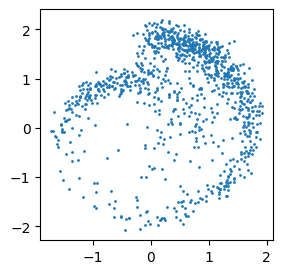

In [17]:
# Entrenamiento:
dsm_net = ScoreNetwork(data_dim=2)
dsm_optimizer = optim.Adam(dsm_net.parameters(), lr=3e-4)
SM.train_model(dsm_net, dsm_optimizer,dsm=True, n_iters=30000)

# Generación de muestras:
dsm_samples = SM.generate_samples(dsm_net, n_samples=1000)
plt.figure(figsize=(3, 3))
plt.scatter(dsm_samples[:, 0], dsm_samples[:, 1], s=1)
plt.show()

#### Entrenamiento para SM

100%|██████████| 30000/30000 [01:41<00:00, 294.29it/s]


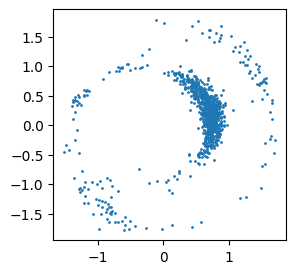

In [18]:
# Entrenamiento:
sm_net = ScoreNetwork(data_dim=2)
sm_optimizer = optim.Adam(sm_net.parameters(), lr=3e-4)
SM.train_model(sm_net, sm_optimizer, dsm=False, n_iters=30000)

# Generación de muestras:
sm_samples = SM.generate_samples(sm_net, n_samples=1000)
plt.figure(figsize=(3, 3))
plt.scatter(sm_samples[:, 0], sm_samples[:, 1], s=1)
plt.show()

- ¿Cuál de los dos entrenamientos toma más tiempo? ¿A qué se debe esto?
> **Respuesta:**
- ¿Cuál de los dos enfoques genera muestras de mejor calidad? ¿A qué se debe esto?
> **Respuesta:**
- ¿Cuál es la limitación del enfoque de DSM que motiva a usar DSM con varios niveles de ruido?
> **Respuesta:**